## 4. Model Optimization – Random Forest Regression

Bu bölümde, feature engineering uygulanmış **movies_fe.csv** datasetini kullanarak
Random Forest tabanlı bir regresyon modeli kuruyor ve optimize ediyorum.

Hedef değişken:
- `vote_average`

Kullanılan metrikler:
- **MAE (Mean Absolute Error)**: Tahmin ile gerçek değer arasındaki ortalama mutlak hata. Ne kadar küçükse o kadar iyi.
- **RMSE (Root Mean Squared Error)**: Büyük hatalara daha fazla ceza veren hata metriği. Yine ne kadar küçükse o kadar iyi.
- **R² (R-kare)**: Modelin varyansı ne kadar açıkladığını gösterir. 0–1 aralığında, 1’e yaklaştıkça daha iyi.

In [35]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [36]:
df = pd.read_csv("/content/data/processed/movies_fe.csv")
df.head()

,budget,genres,id,keywords,popularity,revenue,runtime,title,vote_average,vote_count,...,genre_count,keyword_count,budget_log,revenue_log,popularity_log,vote_count_log,runtime_bin,movie_age,budget_per_minute,popularity_per_vote
0,237000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",19995,"[{'id': 1463, 'name': 'culture clash'}, {'id':...",150.437577,2787965087,162.0,Avatar,7.2,11800,...,4,21,19.283571,21.748578,5.020174,9.375940,very_long,16.0,1.462963e+06,0.012748
1,300000000,"[{'id': 12, 'name': 'Adventure'}, {'id': 14, '...",285,"[{'id': 270, 'name': 'ocean'}, {'id': 726, 'na...",139.082615,961000000,169.0,Pirates of the Caribbean: At World's End,6.9,4500,...,3,16,19.519293,20.683485,4.942232,8.412055,very_long,18.0,1.775148e+06,0.030900
2,245000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",206647,"[{'id': 470, 'name': 'spy'}, {'id': 818, 'name...",107.376788,880674609,148.0,Spectre,6.3,4466,...,3,7,19.316769,20.596199,4.685614,8.404472,long,10.0,1.655405e+06,0.024038
3,250000000,"[{'id': 28, 'name': 'Action'}, {'id': 80, 'nam...",49026,"[{'id': 849, 'name': 'dc comics'}, {'id': 853,...",112.312950,1084939099,165.0,The Dark Knight Rises,7.6,9106,...,4,21,19.336971,20.804790,4.730153,9.116799,very_long,13.0,1.515152e+06,0.012333
4,260000000,"[{'id': 28, 'name': 'Action'}, {'id': 12, 'nam...",49529,"[{'id': 818, 'name': 'based on novel'}, {'id':...",43.926995,284139100,132.0,John Carter,6.1,2124,...,3,16,19.376192,19.464974,3.805039,7.661527,long,13.0,1.969697e+06,0.020672


## Sayısal Feature’ları seç

Burada string kolonlar (genres, keywords, title, runtime_bin vs.) tamamen dışarıda bırakılıyor.

In [37]:
numeric_features = [
    "budget_log",
    "revenue_log",
    "popularity_log",
    "vote_count_log",
    "runtime",
    "genre_count",
    "keyword_count",
    "movie_age",
    "budget_per_minute",
    "popularity_per_vote",
]

target = "vote_average"

X = df[numeric_features].copy()
y = df[target].copy()

## NaN / Infinity temizliği

In [38]:
X = X.replace([np.inf, -np.inf], np.nan)
X = X.fillna(0)

## Train-Test Split

In [39]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

## Baseline Random Forest Modeli

In [40]:
baseline_rf = RandomForestRegressor(
    random_state=42,
    n_jobs=-1
)

baseline_rf.fit(X_train, y_train)
y_pred_base = baseline_rf.predict(X_test)

## Baseline Performans Metrikleri

In [41]:
mae_base = mean_absolute_error(y_test, y_pred_base)
rmse_base = np.sqrt(mean_squared_error(y_test, y_pred_base))
r2_base = r2_score(y_test, y_pred_base)

print(f"Baseline MAE : {mae_base:.4f}")
print(f"Baseline RMSE: {rmse_base:.4f}")
print(f"Baseline R²  : {r2_base:.4f}")

Baseline MAE : 0.5425
Baseline RMSE: 0.7535
Baseline R²  : 0.6235


## RandomizedSearchCV için parametre ızgarası

In [42]:
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
    "n_estimators": [100, 200, 300, 400, 500],
    "max_depth": [None, 5, 10, 15, 20, 30],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2", None]
}

## RandomizedSearchCV

In [43]:
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,                # 20 kombinasyon dener — hızlı ama etkili
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    random_state=42,
    verbose=1
)

## Modeli Optimize

In [44]:
random_search.fit(X_train, y_train)
best_model = random_search.best_estimator_
best_model

Fitting 3 folds for each of 20 candidates, totalling 60 fits


RandomForestRegressor(max_depth=15, max_features=None, min_samples_leaf=4,
                      min_samples_split=5, n_estimators=200, n_jobs=-1,
                      random_state=42)

## Optimize edilmiş model ile test tahmini

In [45]:
y_pred_opt = best_model.predict(X_test)

## Optimize Model Performansı

In [46]:
mae_opt = mean_absolute_error(y_test, y_pred_opt)
rmse_opt = np.sqrt(mean_squared_error(y_test, y_pred_opt))
r2_opt = r2_score(y_test, y_pred_opt)

print(f"Optimized MAE : {mae_opt:.4f}")
print(f"Optimized RMSE: {rmse_opt:.4f}")
print(f"Optimized R²  : {r2_opt:.4f}")

Optimized MAE : 0.5359
Optimized RMSE: 0.7486
Optimized R²  : 0.6283


 # Final Model Performance Summary

Aşağıda baseline model ile optimize edilmiş Random Forest modelinin
performans karşılaştırması verilmiştir.

**Baseline Random Forest Model**
- MAE  : 0.5425
- RMSE : 0.7535
- R²   : 0.6235

**Optimized Random Forest Model**
- MAE  : 0.5359
- RMSE : 0.7486
- R²   : 0.6283

**Sonuç**
- Optimize modelde MAE ve RMSE değerleri iyileşti.
- R² değeri arttı, modelin açıklayıcılığı yükseldi.
- Random Forest, bu veri seti için en tutarlı ve en iyi performansı veren model oldu.
- Veri setinin doğası gereği (yüksek noise ve eksik explanatory değişkenler),
optimizasyon sonrası sınırlı ama anlamlı bir gelişme elde edildi.

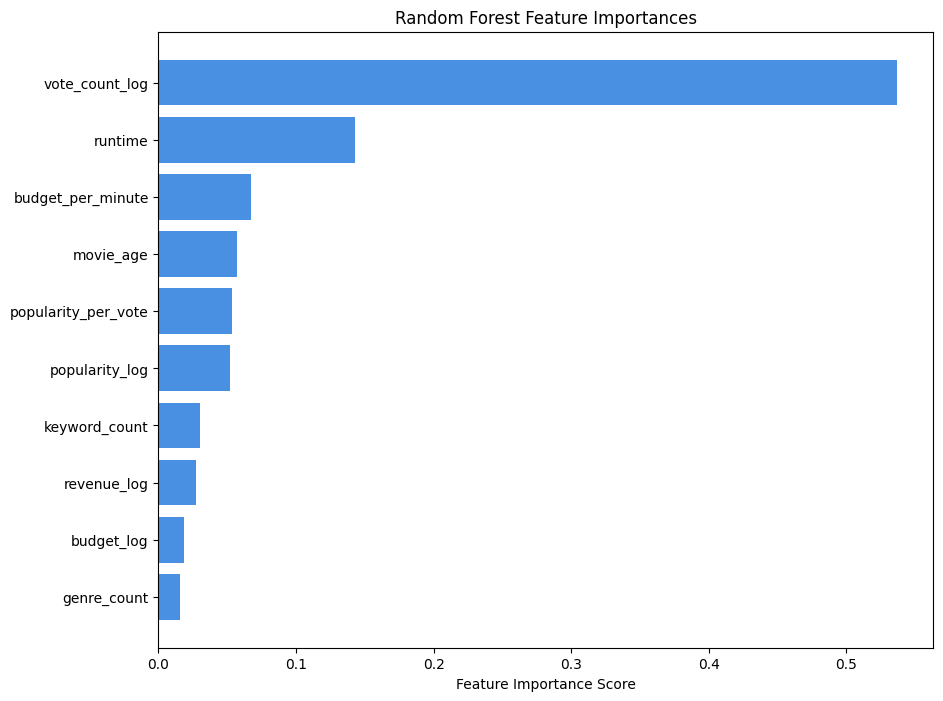

In [48]:
# ---- Feature Importance ---- #

importances = best_model.feature_importances_
feature_names = X_train.columns

# Önem sırasına göre sırala
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[indices], importances[indices], color="#4a90e2")
plt.xlabel("Feature Importance Score")
plt.title("Random Forest Feature Importances")
plt.gca().invert_yaxis()  # En önemli özellik en üstte görünsün
plt.show()